# UFO Sightings - Part 2: Data Visualization and Analysis

## 1. Importing Data Set and Necessary Packages

In [1]:
# IMPORT NECESSARY PACKAGES
import html                           # package used to convert text
import matplotlib.pyplot as plt       # plotting package
import numpy as np                    # linear algebra
import os                             # package used to set work directory
import pandas as pd                   # package used to create dataframes
import re                             # regular expressions
import warnings                       # package used to ignore warnings

from collections import Counter       # counting unique words in string
from datetime import datetime, time   # package used to convert string to datetime 
from operator import itemgetter       # package used for sorted, max, min 
from wordcloud import STOPWORDS       # importing stopwords to exclude from the wordcloud
from wordcloud import WordCloud       # wordcloud

# the following packages are all for geo stuff
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from shapely.geometry import Point
    import geopandas as gpd
    from geopandas import GeoDataFrame
    import geodatasets
    # returns warning (now ignored) because of some outdated functions which we don't use

In [2]:
data = pd.read_csv('preprocessed_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80330 entries, 0 to 80329
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datetime         80330 non-null  object 
 1   city             80330 non-null  object 
 2   state            74533 non-null  object 
 3   country          70660 non-null  object 
 4   shape            80330 non-null  object 
 5   duration         80330 non-null  float64
 6   comments         80330 non-null  object 
 7   date_posted      80330 non-null  object 
 8   latitude         80330 non-null  float64
 9   longitude        80330 non-null  float64
 10  comments_length  80330 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 6.7+ MB


This all looks good. We just need to convert the times again.

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['date_posted'] = pd.to_datetime(data['date_posted'])

We copy the data so we can apply additional data manipulation if needed.

In [5]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80330 entries, 0 to 80329
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         80330 non-null  datetime64[ns]
 1   city             80330 non-null  object        
 2   state            74533 non-null  object        
 3   country          70660 non-null  object        
 4   shape            80330 non-null  object        
 5   duration         80330 non-null  float64       
 6   comments         80330 non-null  object        
 7   date_posted      80330 non-null  datetime64[ns]
 8   latitude         80330 non-null  float64       
 9   longitude        80330 non-null  float64       
 10  comments_length  80330 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(5)
memory usage: 6.7+ MB


## 2. Visualization and Analysis

The sightings span over more than a century. We want to visualize the course of the number of UFO sightings over the years. We start off by counting the number of UFO sightings for each year.

In [6]:
sightings_per_year = pd.DataFrame([i.year for i in df['datetime']], columns=['year'])['year'].value_counts()
years = sightings_per_year.index.tolist()    # indices of the years in sightings_per_year
freqs = sightings_per_year.values.tolist()   # number of sightings extracted from sightings_per_year

Then, we sort the list of number of sightings from the earliest to the most recent. For this, we use all of the years in which sightings have been reported. These are stored in `years`. The indices that correspond to the years are then used to order the counts by year.

In [7]:
sorted_years_index = [i for i, j in sorted(enumerate(years), key=itemgetter(1))]
sorted_years = [j for i, j in sorted(enumerate(years), key=itemgetter(1))]
sorted_years_freqs = [freqs[i] for i in sorted_years_index]

We can now plot the course of the number of UFO sightings over time.

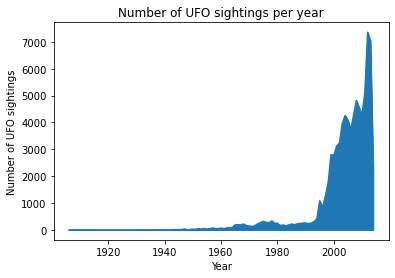

In [8]:
plt.plot(sorted_years, sorted_years_freqs)
plt.fill_between(sorted_years, sorted_years_freqs, color='#1f77b4')
plt.xlabel('Year')
plt.ylabel('Number of UFO sightings')
plt.title('Number of UFO sightings per year')
plt.show()

As can be seen in the figure above, the number of reported UFO sightings per year has increased over the years. However, we can't really tell from this data set alone whether there have actually been more sightings or not. Since the data has been scraped, it makes sense that with the spread and improvement of communication technology the reported UFO sightings would also increase. 

The data not online contains years and months, but also the exact date and time of the sighting. We can create a heatmap to analyze the effect of the weekday and the hour of the day on the number of reported sightings. We first start of by creating an array that contains the number of sightings for every hour of every day of the week. We need to define a function that checks whether a sighting occured on a certain weekday during a certain hour of the day. This function will be called `check_hourday`. Then, a empty list is initialized which will store all number of sightings. This list will grow in the for loop as it iterates over the weekdays and hours. Finally, the list is reshaped into a two-dimensional array with each row corresponding to a weekday.

In [9]:
def check_dayhour(start, end, day, timestamp):
    return ((timestamp.time() >= start) & (timestamp.time() < end) & (timestamp.weekday() == day))

heatmap_list = []

for day in range(7):
    for i in range(24):
        if i !=23:
            heatmap_list += [sum([1 if check_dayhour(time(i,0), time(i+1,0), day, t) else 0 for t in df['datetime']])]
        else:
            heatmap_list += [sum([1 if check_dayhour(time(23,0), time(23,59), day, t) else 0 for t in df['datetime']])]
            
heatmap_array = np.array(heatmap_list).reshape(7,24)

We can now use the array to create a heatmap.

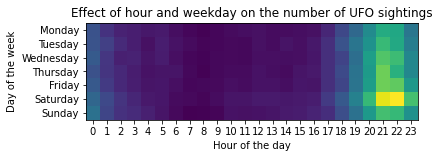

In [10]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots()
im = ax.imshow(heatmap_array)
ax.set_xticks(np.arange(24), labels=range(24))
ax.set_yticks(np.arange(7), labels=weekdays)
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Day of the week')
ax.set_title('Effect of hour and weekday on the number of UFO sightings')
fig.tight_layout()
plt.show()

This heatmap shows that most sightings occured later in the evening with a significant peak on Saturday nights. Saturday night is tyically when people have time off and like to enjoy themselves and go out. It makes sense that there would be at peak in sightings during those hours. Also, later in the evening is also when it's quite dark outside, so moving objects are harder to identify which may be why they could be reported as a UFO. 

To continue the train of thought of the effect of leasure time on the number of sightings, we'll investigate what the numbers look like for different times of the year. We categorize the data based on the month the sightings happened in, count the sightings and visualize these numbers in a bar plot.

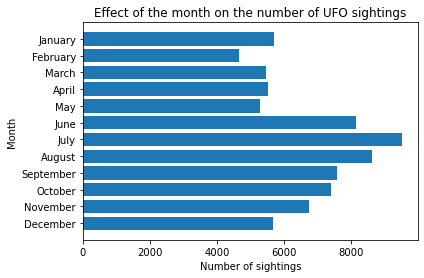

In [11]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sightings_month = {}
for i in range(1,13):
    sightings_month[months[i - 1]] = sum([1 if (f'-{i:02.0f}-' in str(line)) else 0 for line in df['datetime']])

sightings_month_list = [sightings_month[month] for month in months]

plt.barh(months[-1:-13:-1], sightings_month_list[-1:-13:-1])
plt.xlabel('Number of sightings')
plt.ylabel('Month')
plt.title('Effect of the month on the number of UFO sightings')
plt.show()

As one may expect, there are significantly more sightings during the months in which the northern hemisphere is going through summer. We will shortly analyze the location data to see if the reports are mostly coming from the northern hemisphere. If that turns out to be the case, it would make sense since that's when people go out more as the weather allows it and the school are closed. Below, we plot the geographical coordinates on the world map.

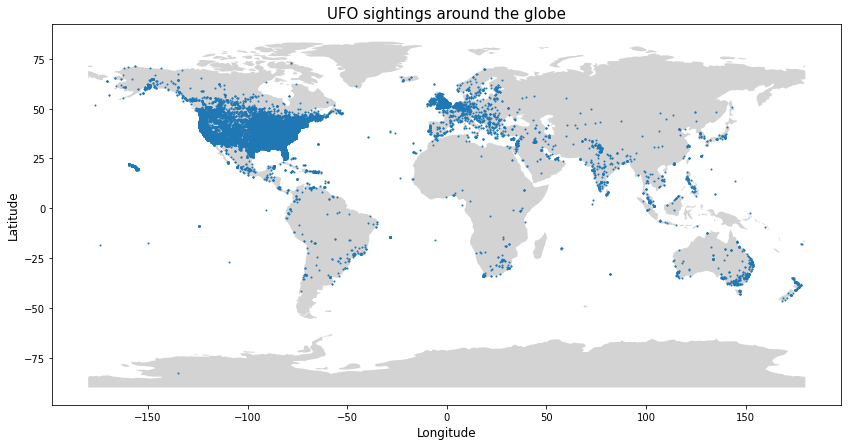

In [12]:
# Set up the geometry for the GeoDataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

# Load the world map
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

# Create figure and axes
fig, ax = plt.subplots(figsize=(16, 7))

# Plot the world map on the axes
world.plot(ax=ax, color='lightgray')

# Plot the data (UFO sightings) on the same axes
gdf.plot(ax=ax, marker='o', color='#1f77b4', markersize=1)

# Add labels and title
ax.set_title("UFO sightings around the globe", fontsize=15)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.show()

As suspected, most of the sightings occured in the northern hemisphere, especially in North America and Europe. There are also significant clusters in the Indian subcontinent and Australia. These are countries where you'll find many English speaking people. Let's look at the numbers.

In [13]:
print(df['country'].value_counts())

country
us    65112
ca     3000
gb     1905
au      538
de      105
Name: count, dtype: int64


Right away it can be seen that the majority of the sightings have to be reported in the United States. Percentages will make it even more clear.

In [14]:
df['country'].value_counts()/sum(df['country'].value_counts())*100

country
us    92.148316
ca     4.245684
gb     2.696009
au     0.761393
de     0.148599
Name: count, dtype: float64

More than four fifths of the sightings have been reported to have taken place in the US. About 12 percent of the sightings in the data set were outside the five specified countries: The US, Canada, Great Britain, Australia and Germany. This means that the data are heavily skewed toward the United States. Let's zoom in.

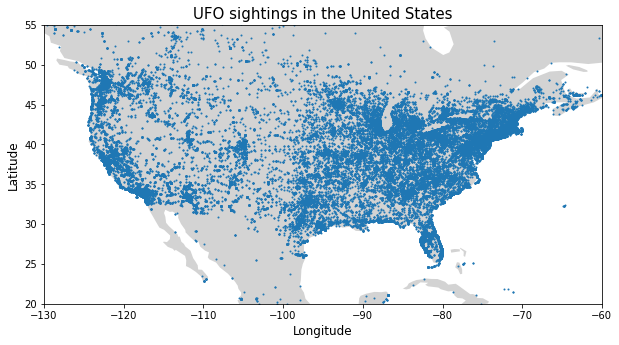

In [15]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgray')
gdf.plot(ax=ax, marker='o', color='#1f77b4', markersize=1)
ax.set_xlim([-130, -60])  # Longitude limits (approximate for USA)
ax.set_ylim([20, 55])     # Latitude limits (approximate for USA)
ax.set_title("UFO sightings in the United States", fontsize=15)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
plt.show()

Take any population density map of the United States and it would look somewhat like the map above. There is not much that can be inferred from this map. We will now move on to the other columns and include them in the analysis.

It may be a little late, but it seems to be useful to create new columns with all the time elements for easy access. Since the other pieces of codes find above have been an interesting exercise, we will leave it as it is. However, for the remainder of this analysis, we will be using the added columns. There will be seven new columns containing year, month, day, hour, minute and weekday (two columns) extracted from `datetime`.

In [16]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.day_name()
df = df.astype({'weekday':'string'})            # weekday as string (Monday - Sunday)
df['weekday_num'] = df['datetime'].dt.weekday   # weekday as integer (0 - 6)
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute

There are other time data we haven't yet analyzed. One is the time of the comment, which is the time at which the sighting was shared with others/the public. The other is the duration of the sightings. We'll use the time of the comment to calculate the number of days between the sighting and the actual reporting.

In [17]:
df['time_difference'] = (df['date_posted'] - df['datetime']).dt.days

A histogram can give us a general insight in the time between a sighting and the reporting.

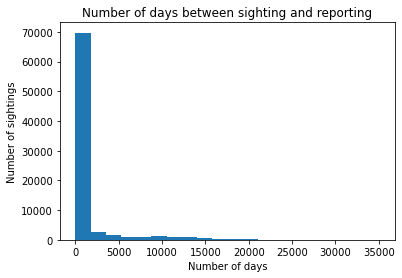

In [18]:
plt.hist(df['time_difference'], bins=20)
plt.xlabel('Number of days')
plt.ylabel('Number of sightings')
plt.title('Number of days between sighting and reporting')
plt.show()

Most reportings have been done within 7 years. This is due to the many outliers ('many' because we're dealing with a large data set). Let's look at the third quantile. 

In [19]:
print(df['time_difference'].quantile(0.75))

119.0


This means that 75 percent of the sightings were reported within 119 days after they happened. Let plot the histogram for these specific sightings.

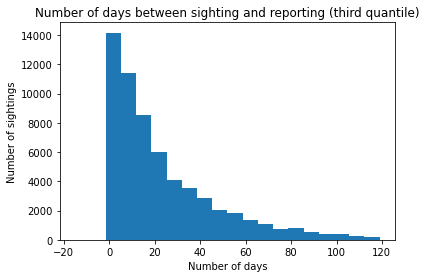

In [20]:
time_dif_q3 = df['time_difference'][df['time_difference'] <= 119] 
plt.hist(time_dif_q3, bins=20)
plt.xlabel('Number of days')
plt.ylabel('Number of sightings')
plt.title('Number of days between sighting and reporting (third quantile)')
plt.show()

From this histogram we can derive that most people report their UFO sightings within a few weeks. The longer the time difference between sighting and reporting, the smaller the subset. Notice how a few time differences seem to be negative (i.e., the reporting was somehow earlier than the sighting itself). 

In [21]:
print(sum(df['time_difference'] < 0))

357


There are 357 sightings where this has been the case.

In [22]:
print(df['time_difference'].loc[df['time_difference'] < 0].value_counts())

time_difference
-1     352
-2       4
-15      1
Name: count, dtype: int64


From those 357 sightings, 352 have a time difference of one day. If you look at some of them, it seems that it is caused by the fact that the sighting was reported on the same day. Since `date_posted` does not contain times as opposed to `datetime`, only dates, the time difference will be negative. For the other five reportings there must have been made mistakes during either the reporting or scraping process. We will set all of these negative time differences to zero.

In [23]:
df.loc[df['time_difference'] < 0, 'time_difference'] = 0

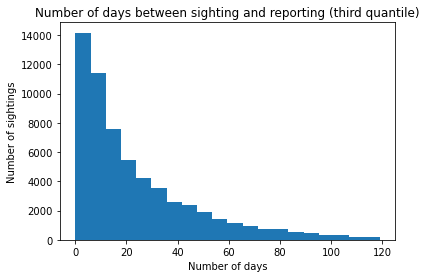

In [24]:
time_dif_q3 = df['time_difference'][df['time_difference'] <= 119] 
plt.hist(time_dif_q3, bins=20)
plt.xlabel('Number of days')
plt.ylabel('Number of sightings')
plt.title('Number of days between sighting and reporting (third quantile)')
plt.show()

Above you find the histogram after the correction.

Now let's look into the duration of the sightings.

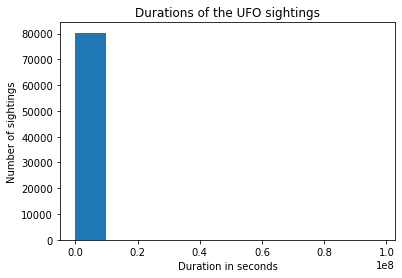

In [25]:
plt.hist(df['duration'], bins=10)
plt.xlabel('Duration in seconds')
plt.ylabel('Number of sightings')
plt.title('Durations of the UFO sightings')
plt.show()

Again, their seem to be quite some outliers. We will look at the third quantile again.

In [26]:
print(df['duration'].quantile(0.75))

600.0


The third quantile is found at 600 seconds (i.e., 10 minutes).

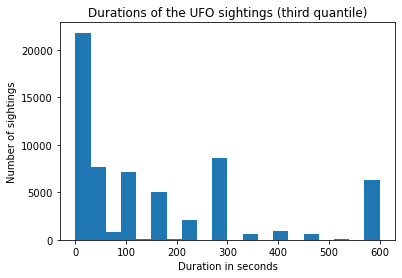

In [27]:
duration_dif_q3 = df['duration'][df['duration'] <= 600] 
plt.hist(duration_dif_q3, bins=20)
plt.xlabel('Duration in seconds')
plt.ylabel('Number of sightings')
plt.title('Durations of the UFO sightings (third quantile)')
plt.show()

Most sightings were just a couple of minutes.

We will now look at the length of the comments come with the reported sightings. A histogram can give us a nice first insight.

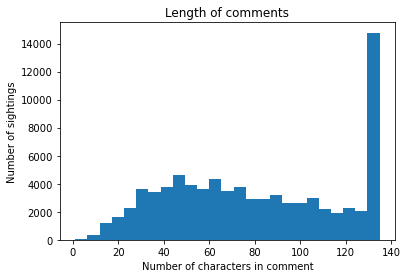

In [28]:
plt.hist(df['comments_length'], bins=25)
plt.xlabel('Number of characters in comment')
plt.ylabel('Number of sightings')
plt.title('Length of comments')
plt.show()

The first things that jumps out is that a large part of the comments is found in the last bin. When you open randomly go through some of the comments, you'll notice that some of them seem to have been cut off. Whoever scraped the data must have capped the character limit. 

In [29]:
max_comments_length = max(df['comments_length'])
number_of_capped_comments = len(np.where(df['comments_length'] == max_comments_length)[0])
print(f'{number_of_capped_comments} of comments have been capped at a character limit of {max_comments_length}')

9641 of comments have been capped at a character limit of 135


There are 9,641 comments that have been capped at a character limit. This limit seems to have been set at 135 characters by whomever scraped the data.

The last aspect we will analyze is the shape of the alleged UFOs. In Part 1, we saw that there are 29 different unique values for `shape`. 

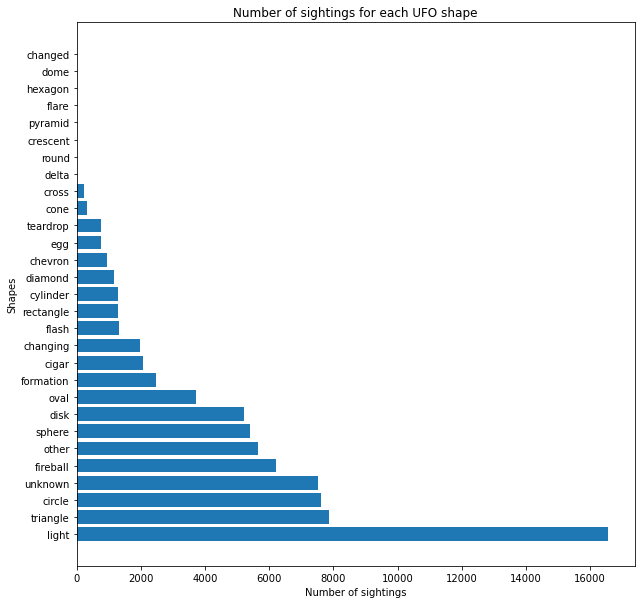

In [30]:
shape_unique_counts = df['shape'].value_counts()
unique_shapes = shape_unique_counts.index
numbers_unique_shapes = shape_unique_counts.values

plt.figure(figsize=(10, 10))
plt.barh(unique_shapes, numbers_unique_shapes)
plt.xlabel('Number of sightings')
plt.ylabel('Shapes')
plt.title('Number of sightings for each UFO shape')
plt.show()

A large part of the alleged UFOs were either some kind of light ('light', 'fireball' and 'flash'). One may wonder at what times the different shapes were seen. We're going to create a heatmap like we did for the one for weekday and hour. However, this time we will be using `np.where()`, which is way faster than the method we tried earlier.

In [31]:
heatmap_shape_hour = []
for hour in range(24):
    for shape in unique_shapes:
        heatmap_shape_hour += [len(np.where((df['shape'] == shape) & (df['hour'] == hour))[0])]

heatmap_shapehour_array = np.array(heatmap_shape_hour).reshape(24,29)

We can now create the heatmap.

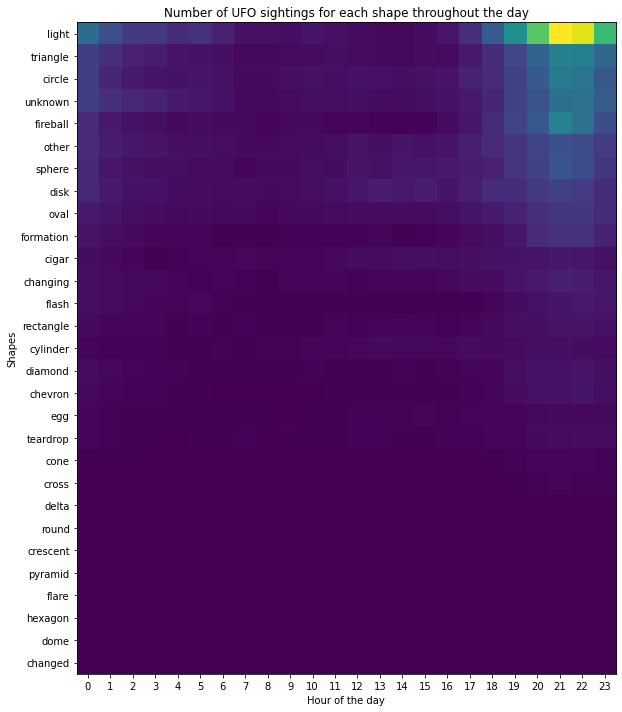

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(heatmap_shapehour_array.transpose())
ax.set_xticks(np.arange(24), labels=range(24))
ax.set_yticks(np.arange(len(unique_shapes)), labels=unique_shapes, rotation='horizontal')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Shapes')
ax.set_title('Number of UFO sightings for each shape throughout the day')
fig.tight_layout()
plt.show()

At first sight, the heatmap seems to show that the sightings happen mostly in the evening for all shapes. However, when we look more carefully, we see that this may not necessarily be true for all of the shapes. We should drop some of the shapes to correct the proportions. We begin by dropping the smallest eight shape groups. We're also going to drop the first one which is by far the largest group.

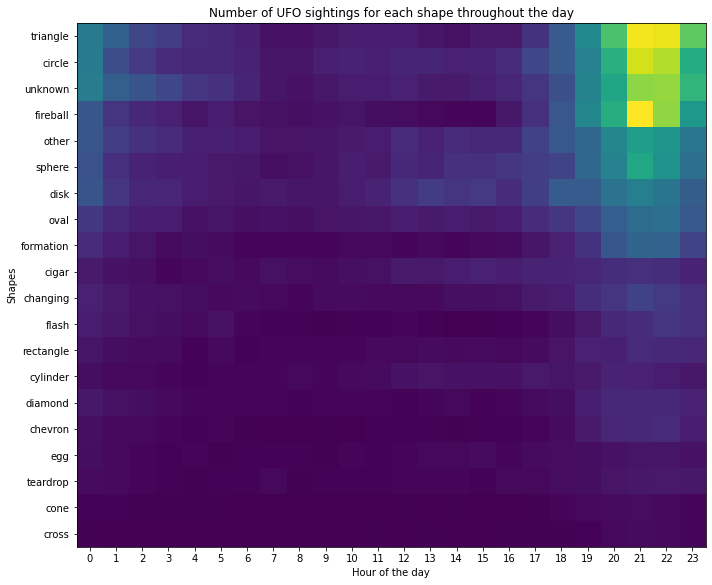

In [33]:
m = 1
n = 8
p = m + n

heatmap_shapehour_array_mn= np.array(heatmap_shape_hour).reshape(24,29)[:, m:-n]

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(heatmap_shapehour_array_mn.transpose())
ax.set_xticks(np.arange(24), labels=range(24))
ax.set_yticks(np.arange(len(unique_shapes)-p), labels=unique_shapes[m:-n], rotation='horizontal')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Shapes')
ax.set_title('Number of UFO sightings for each shape throughout the day')
fig.tight_layout()
plt.show()

This heatmap somehwat shows a pattern. Most sightings took place later in the evening. However, there are a few shapes that seem to have been sighted throughout the day. Or at least during the hours most people are awake. The following shapes will be examined a bit more: other, disk, cigar, cylinder.

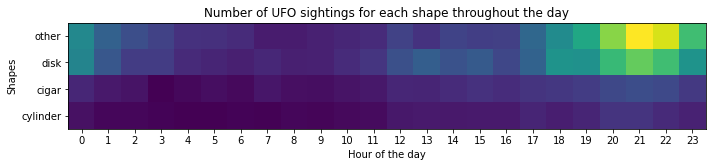

In [34]:
selected_shapes = ['other', 'disk', 'cigar', 'cylinder']
shapes_ind = [unique_shapes.to_list().index(shape) for shape in selected_shapes]

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(heatmap_shapehour_array[:,shapes_ind].transpose())
ax.set_yticks(np.arange(len(selected_shapes)), labels=selected_shapes, rotation='horizontal')
ax.set_xticks(np.arange(24), labels=range(24))
ax.set_ylabel('Shapes')
ax.set_xlabel('Hour of the day')
ax.set_title('Number of UFO sightings for each shape throughout the day')
fig.tight_layout()
plt.show()

As it turns out, the pattern is actually also perceived in these four shapes. In the big heatmap, it just looked like the sightings were more distributed over the day due to the neighboring colors. In the heatmap above, you can see that for these four shapes the sightings also occur mostly later in the evening.

We're now going to look at is the different shapes sighted around the world. We could plot all of them in the same figure and give the dots different colors. There are more than 80,000 sightings, so you probably not see much. Instead, we create a function that takes the shape and plots only the sightings of that specific shape. We will focus on the United States for now.

In [35]:
def plot_shape_on_map(shape):
    df_cross = df.iloc[np.where(df['shape'] == shape)]
    
    geometry = [Point(xy) for xy in zip(df_cross['longitude'], df_cross['latitude'])]
    gdf = GeoDataFrame(df_cross, geometry=geometry)
    world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
    fig, ax = plt.subplots(figsize=(10, 6))
    world.plot(ax=ax, color='lightgray')
    gdf.plot(ax=ax, marker='o', color='#1f77b4', markersize=8)
    ax.set_title(f"UFO sightings of the {shape} shape in the United States", fontsize=15)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.set_xlim([-130, -60])  # Longitude limits (approximate for USA)
    ax.set_ylim([20, 55])     # Latitude limits (approximate for USA)
    plt.show()

We're not going to plot the sightings for each individual shape. Instead, we're going to focus on a few interesting shapes. First, we start with the cross shape. The cross has religious connotations. There are some areas in the United States that are known for religion to have a more central role in the lives of the people there. 

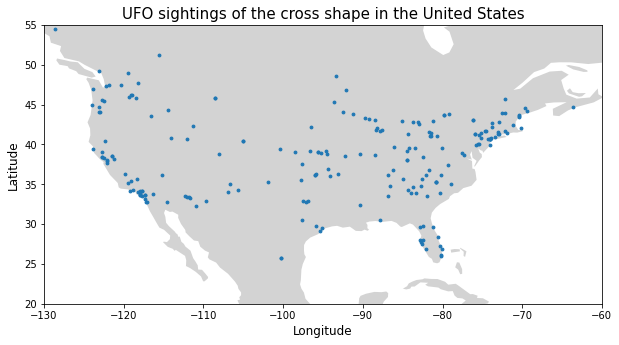

In [36]:
plot_shape_on_map('cross')

There doesn't seem to be a clear clustering of the cross sightings. The sightings seem to be fairly evenly spread over the country with respect to population density and the overall spread of all sightings. We'll create the plot for three more shapes to see if it is any different for those shapes.

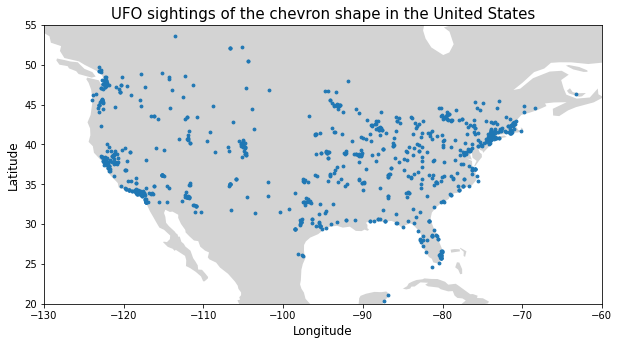

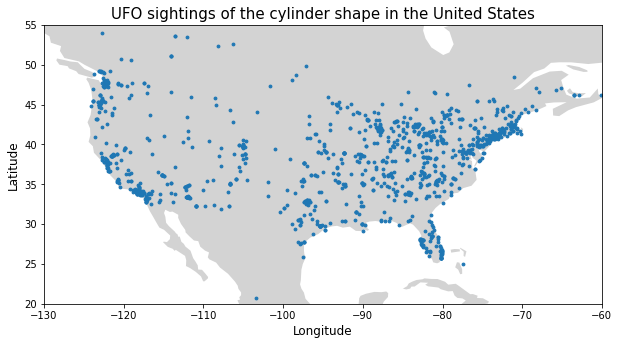

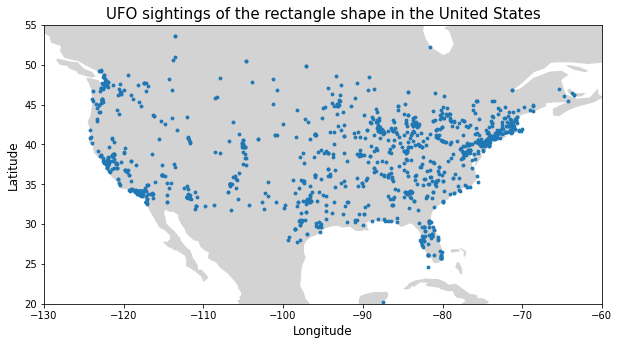

In [37]:
plot_shape_on_map('chevron')
plot_shape_on_map('cylinder')
plot_shape_on_map('rectangle')

It seems to be the same for these shapes as well.

Now let's look at how the time between sighting and reporting differs for each shape.

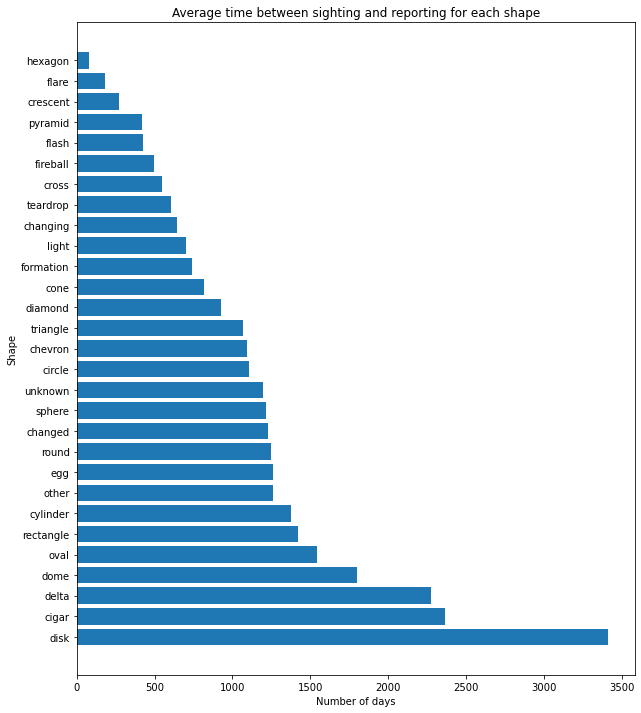

In [38]:
time_dif_shape = []
for shape in unique_shapes:
     time_dif_shape += [float(np.mean(df['time_difference'].iloc[np.where(df['shape'] == shape)]))]

time_dif_shape_sorted = [shape[1] for shape in sorted(enumerate(time_dif_shape), key=itemgetter(1))]
time_dif_shape_ind = [shape[0] for shape in sorted(enumerate(time_dif_shape), key=itemgetter(1))]
time_dif_shape_sorted_names = [unique_shapes.to_list()[i] for i in time_dif_shape_ind]

plt.figure(figsize=(10, 12))
plt.barh(time_dif_shape_sorted_names[-1:-30:-1], time_dif_shape_sorted[-1:-30:-1], height=0.8)
plt.xlabel('Number of days')
plt.ylabel('Shape')
plt.title('Average time between sighting and reporting for each shape')
plt.show()

There is an overall pattern that could be perceived in the bar chart above. The geometric shapes on average are being reported much later after the sighting than other shapes. This could probably be due to those other shapes potentially being more interesting and nameworthy than the simple geometric shapes.

Finally, we'll analyze the comments. This isn't going to be very indepth. If one wants to do deeper analysis, sentiment analysis would be an appropriate way to go. For now, we will just focus on a simple dive into the comments. We start off by join all the comments together.

In [39]:
all_comments = " ".join(comment for comment in df['comments'])

Now, we can create the word cloud using the `WordCloud` package. We filter out stopwords which are words that naturally occur a lot in texts (the, and, or etc.). For this, we use the `STOPWORDS` package.

In [40]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').generate(all_comments)

Let's now plot the word cloud.

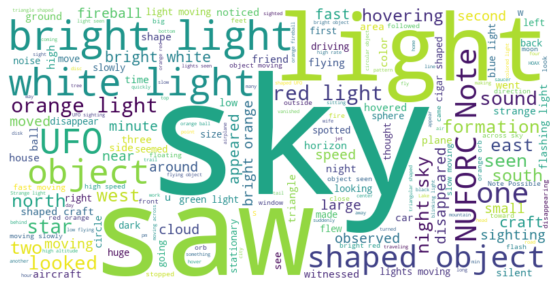

In [41]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Geen assen tonen
plt.show()

Many of the words are visual descriptions of the UFOs that are claimed to have been sighted, which of course makes sense. That's what we would expect. There are also some words that would describe the situational aspects, like the time of the day, duration, location and what the sky looked like.

To narrow down the analysis, we will use the `Counter` package to find the top 20 most common words in the comments leaving out stopwords.

In [42]:
# Remove all special characters and convert all letters to lower case
all_comments_cleaned = re.sub(r'\W+', ' ', all_comments).lower()

# Seperate all words
word_list = all_comments_cleaned.split()

# Exclude stopwords and count unique words
filtered_words = [word for word in word_list if word not in stopwords]
word_counts_filtered = Counter(filtered_words)

# Top 20 most common words
top_20_filtered_words = word_counts_filtered.most_common(20)

These top 20 most commons words are then presented in a bar plot.

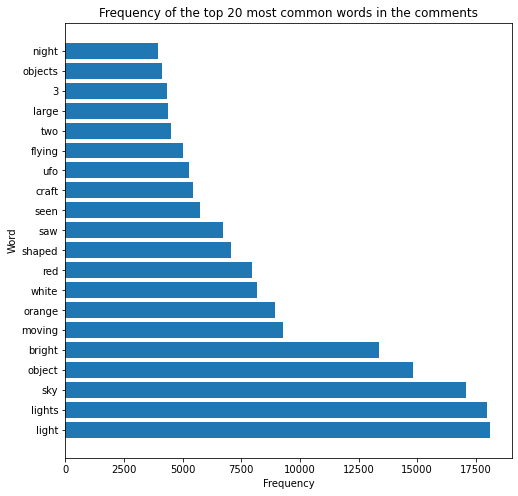

In [43]:
top20_words = [tup[0] for tup in top_20_filtered_words]
top20_counts = [tup[1] for tup in top_20_filtered_words]

plt.figure(figsize=(8, 8))
plt.barh(top20_words, top20_counts)
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Frequency of the top 20 most common words in the comments')
plt.show()

We saw before that the shapes 'light', 'fireball' and 'flash' make up quite a significant part of the sightings. The top two words are 'light' and 'lights', so that corresponds to the shape counts. It makes sense that 'night' is on the 20th place in the top 20. Lights are more noticeable during the night. The three colors 'orange', 'white' and 'red' obviously describe light and fire. The other words in the top 20 pertain to the act of *perceiving* and to other common descriptions of UFOs and the sky.

## 3. Summary

Most UFO sightings took place later in the evening between 8 and 11 p.m. with a peak on Saturday nights. The number of sightings increases during the summer. More than 80 percent of the reports came from the United States and were fairly evenly spread over the country with respect to the population density. The majority of the sightings were reported to have lasted for a couple of minutes. Most people reported their sightings within a couple of weeks after it happened. The comments of the reports have been capped by a 135 character limit. UFOs that were of more interesing shapes were more quickly shared than UFOs that were of simple geometric shapes.